# Habitable Planet Prediction Model

**Name:** Krishna Sikheriya  
**Roll Number:** IIT2023139  
**College:** IIIT Allahabad  
**Github Username:** Krishna200608  

---

## Objective
To predict the potential habitability of exoplanets using the PHL Exoplanet Catalog, restricted to a specific set of 30 physical and orbital features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set random seed for reproducibility
np.random.seed(42)

## 1. Data Loading

In [2]:
# Load the dataset
data_path = '../data/full_data.csv' 
try:
    df = pd.read_csv(data_path)
    print("Dataset loaded successfully.")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print("File not found. Please check the path.")

Dataset loaded successfully.
Shape: (4048, 112)


## 2. Feature Selection
Restricting the dataset to the allowed 30 features + Target Variable.

In [3]:
allowed_features = [
    # Planet Physical Properties
    'P_MASS', 'P_RADIUS', 'P_DENSITY', 'P_GRAVITY', 'P_ESCAPE', 'P_TYPE',
    # Planet Orbital Parameters
    'P_PERIOD', 'P_SEMI_MAJOR_AXIS', 'P_ECCENTRICITY', 'P_INCLINATION', 
    'P_OMEGA', 'P_PERIASTRON', 'P_APASTRON', 'P_IMPACT_PARAMETER', 'P_HILL_SPHERE',
    # Stellar Properties
    'S_MASS', 'S_RADIUS', 'S_LUMINOSITY', 'S_TEMPERATURE', 'S_AGE', 
    'S_METALLICITY', 'S_LOG_G', 'S_TYPE', 'S_MAG', 'S_DISC', 'S_MAGNETIC_FIELD',
    # System & Meta Data
    'S_SNOW_LINE', 'S_TIDAL_LOCK', 'P_DETECTION', 'P_DISTANCE'
]

target_column = 'P_HABITABLE'

# Filter dataset
# Ensure all columns exist before filtering to avoid errors
existing_features = [col for col in allowed_features if col in df.columns]
missing_features = set(allowed_features) - set(existing_features)

if missing_features:
    print(f"Warning: The following allowed features are missing from the dataset: {missing_features}")

selected_columns = existing_features + [target_column]
df_selected = df[selected_columns].copy()

print(f"Filtered dataset shape: {df_selected.shape}")

Filtered dataset shape: (4048, 31)


## 3. Data Preprocessing

In [4]:
# Handle Target Variable
# Check unique values in P_HABITABLE
print("Target variable distribution:\n", df_selected[target_column].value_counts())

# Convert to binary classification: 0 (Non-Habitable), 1 (Habitable - Conservative or Optimistic)
# Assuming 0 = Non-habitable, 1 = Conservatively Habitable, 2 = Optimistically Habitable
df_selected['Target'] = df_selected[target_column].apply(lambda x: 1 if x > 0 else 0)

# Drop original target column
df_selected.drop(columns=[target_column], inplace=True)

print("Binary Target distribution:\n", df_selected['Target'].value_counts())

Target variable distribution:
 P_HABITABLE
0    3993
2      34
1      21
Name: count, dtype: int64
Binary Target distribution:
 Target
0    3993
1      55
Name: count, dtype: int64


In [5]:
# Splitting Features and Target
X = df_selected.drop(columns=['Target'])
y = df_selected['Target']

# Identify Categorical and Numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['number']).columns

print(f"Categorical Columns: {list(categorical_cols)}")
print(f"Numerical Columns: {list(numerical_cols)}")

Categorical Columns: ['P_TYPE', 'S_TYPE', 'P_DETECTION']
Numerical Columns: ['P_MASS', 'P_RADIUS', 'P_DENSITY', 'P_GRAVITY', 'P_ESCAPE', 'P_PERIOD', 'P_SEMI_MAJOR_AXIS', 'P_ECCENTRICITY', 'P_INCLINATION', 'P_OMEGA', 'P_PERIASTRON', 'P_APASTRON', 'P_IMPACT_PARAMETER', 'P_HILL_SPHERE', 'S_MASS', 'S_RADIUS', 'S_LUMINOSITY', 'S_TEMPERATURE', 'S_AGE', 'S_METALLICITY', 'S_LOG_G', 'S_MAG', 'S_DISC', 'S_MAGNETIC_FIELD', 'S_SNOW_LINE', 'S_TIDAL_LOCK', 'P_DISTANCE']


In [6]:
# Handling Missing Values
# Check for null columns and drop them
null_cols = X.columns[X.isnull().all()]
if len(null_cols) > 0:
    print(f"Dropping columns with all missing values: {list(null_cols)}")
    X.drop(columns=null_cols, inplace=True)
    
    # Update lists of columns
    numerical_cols = X.select_dtypes(include=['number']).columns
    categorical_cols = X.select_dtypes(include=['object']).columns

# For numerical: Impute with median
imputer_num = SimpleImputer(strategy='median')
if len(numerical_cols) > 0:
    X[numerical_cols] = imputer_num.fit_transform(X[numerical_cols])

# For categorical: Impute with mode
imputer_cat = SimpleImputer(strategy='most_frequent')
if len(categorical_cols) > 0:
    X[categorical_cols] = imputer_cat.fit_transform(X[categorical_cols])

Dropping columns with all missing values: ['S_DISC', 'S_MAGNETIC_FIELD']


In [7]:
# Encoding Categorical Variables
le = LabelEncoder()
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

In [8]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (3238, 28)
Testing set size: (810, 28)


In [9]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Model Training

In [10]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Train the model
rf_model.fit(X_train_scaled, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 5. Evaluation

Accuracy Score: 0.9901 (99.01%)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       799
           1       1.00      0.27      0.43        11

    accuracy                           0.99       810
   macro avg       1.00      0.64      0.71       810
weighted avg       0.99      0.99      0.99       810



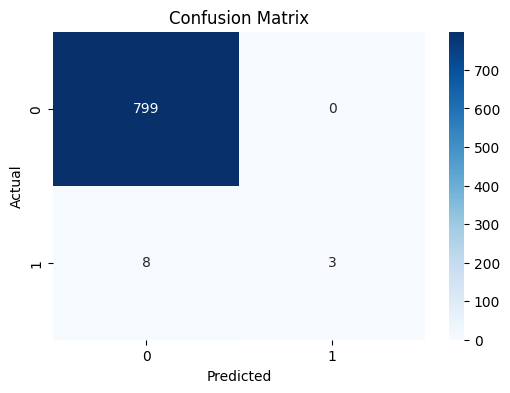

In [11]:
# Predictions
y_pred = rf_model.predict(X_test_scaled)

# Metrics
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {acc:.4f} ({acc * 100:.2f}%)")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

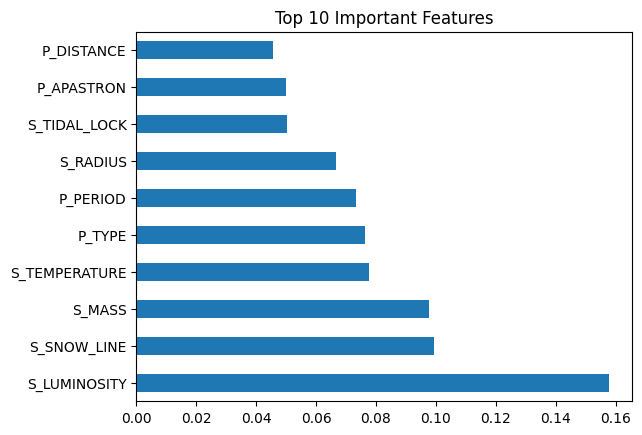

In [12]:
# Feature Importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Important Features')
plt.show()

## 5. Model Saving
Saving the trained Random Forest model using pickle.

In [13]:
import pickle

filename = 'Krishna200608_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(rf_model, file)

print(f"Model saved to {filename}")

Model saved to Krishna200608_model.pkl
